#  **Detección de áreas verdes en CABA utilizando SatProc y Unetseg** 
> ## Dos herramientas de implementación de redes neuronales profundas para la segmentación de imágenes geoespaciales.






##Workshop  2022

In [ ]:
# dependencias
!pip install pysatproc
!pip install folium==0.2.1
!pip install unetseg 
!pip uninstall -y h5py
!pip install h5py==2.10.0 
!pip install unetseg


In [ ]:
# Variable
REPO='gs://dym-workshops-public/
barrio='Belgrano'

Nuestro objetivo es detectar <font color='green'>**áreas verdes**</font> en la Ciudad de Buenos Aires y clasificarlas en dos clases:


*   **Parques**
*   **Vegetación**: arbolado público, boulevares y terrenos valdíos.



![](https://drive.google.com/uc?export=view&id=1X2ZxHFA0BJaSm7qcmhNwqeGp2tA6nLGm) ![](https://drive.google.com/uc?export=view&id=1m2yjwQs7qR5-Z9FqHKLFwDSEE-JEDicp)

**Figura 1**: Ejemplo de la clase Parques (izquierda) y  la clase Vegetación (derecha).

Para ello se aborda un método de data-driven para la segentación semántica, utilizando **imágenes aéreas** y las herramientas de machine learning: <font color='orange'>**unetseg**</font> y <font color='orange'>**satproc**</font>. 
Esto permite tomar ventaja de la disposición de la  información georeferenciada disponible de modo público y gratuito. De igual modo, la implementación de modelos de machine learning permite procesar los datos de grandes extensiones territoriales de modo eficiente y veloz a un bajo costo.


 
Este proyecto está dividido en 3 grandes etapas:

1.  **Entrenamiento**: en primer lugar se crea el dataset que utilizará el modelo para entrenar (dataset de entrenamiento). Luego, en el entrenamiento, el modelo aprende a reconocer los patrones que caracterizan a los objetos de interés. 
2. **Predicción**: se genera el dataset de predicción con el cuál, el modelo entrenado previamente, genera las predicciones sobre estas nuevas imágenes devolviendo la probabilidad de encontrar los objetos. 
3. **Post-procesamiento**: se aplica un umbral a los resultados para conservar los de mayor probabilidad y un filtro de área mínima para descartar polígonos muy pequeños. 

Cada una de estas etapas está descrita en detalle a continuación. 

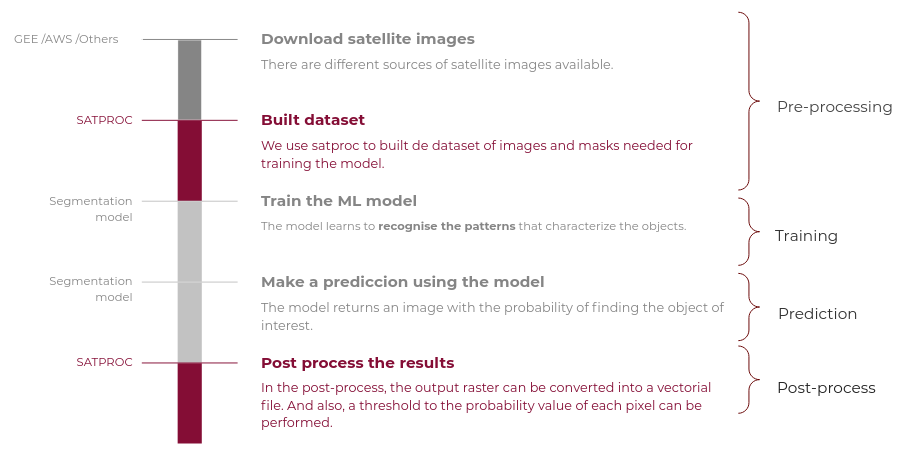

En este workshop mostraremos cómo desarrollar fácilmente el entrenamiento y la predicción con la **red neuronal profunda** de segmentación: U-Net. Para ello utilizaremos las heramientas de código libre <font color='orange'>**Unetseg**</font> y <font color='orange'>**Satproc**</font>, **imágenes aéreas** de la Ciudad de Buenos Aires y **anotaciones** de parques y vegetación de la ciudad.

# **1. Entrenamiento**

 **Descarga de las imagenes AÉREAS**

Podremos descargar las imagenes del siguiente bucket. Éste contiene las imágenes aéreas de los barrios:

*   Belgrano
*   Chacarita
*   Colegiales
*   Palermo
*   Recoleta
*   Villa Crespo





In [ ]:
#import os
#from glob import glob

In [ ]:
barrio='Belgrano'

In [ ]:
path_to_images= './workshop/imagenes/'
#!mkdir -p $path_to_images #crea el directorio

bucket_imagen_caba=os.path.join(REPO + 'gcba/workshop/imagen_2021/2021_RGB_utm.tif') #imagen de CABA utilizada para entrenar

#!gsutil -m cp -r $bucket_imagen_caba $path_to_images #descarga la imagen



In [ ]:
barrio = "Belgrano"
print(f"El {barrio}")

**Descacarga del archivo vectorial de anotaciones**

Este archivo contiene polígonos de las clases parques y vegetación.

In [ ]:
#path_to_gt='./workshop/data/gt/'
#!mkdir -p $path_to_gt
#bucket_gt='gs://dym-workshops-public/gcba/workshop/anotaciones/areas_verdes.gpkg'

#!gsutil -m cp -r  $bucket_gt  $path_to_gt

Copying gs://dym-workshops-public/gcba/workshop/anotaciones/areas_verdes.gpkg...
\ [1/1 files][232.0 MiB/232.0 MiB] 100% Done                                    
Operation completed over 1 objects/232.0 MiB.                                    


**Descarga del vector de área de interés**

El archivo vectorial de área de interés delimita las zonas donde están las anotaciones. Al definirlo, reducimos el tiempo de cómputo ya que no se recorre toda la imágen.

In [ ]:
#path_to_aoi='./workshop/data/shp/ '
#!mkdir -p $path_to_aoi
#bucket_aoi='gs://dym-workshops-public/gcba/workshop/data/shp/aoi_areas_verdes.geojson'

#!gsutil -m cp -r  $bucket_aoi  $path_to_aoi

Copying gs://dym-workshops-public/gcba/workshop/data/shp/aoi_areas_verdes.geojson...
/ [1/1 files][  3.1 KiB/  3.1 KiB] 100% Done                                    
Operation completed over 1 objects/3.1 KiB.                                      


# 1. Pre-procesamiento

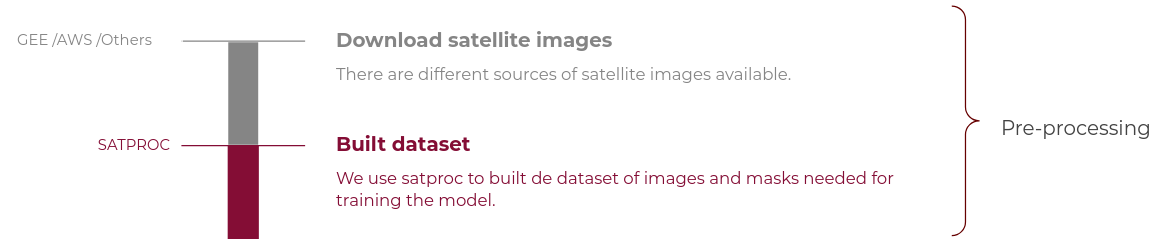



El objetivo del pre-procesamiento es **generar el dataset de entrenamiento** con imágenes de buena calidad, cantidad y formato necesario. Los modelos de segmentación requieren un dataset conformado por **imágenes** y **máscaras** que delimitan el objeto de interés. Estas son imágenes binarias con 1 donde está el objeto y 0 donde no.





 
* Las **imágenes utilizadas** son imágenes aéreas de alta resolución, tomadas desde un avión. Estas son imágenes de tres bandas (RGB), cuentan con una resolución de 8cm y son del año 2021.

 
* La **verdad de campo** utilizada para entrenar al modelo se obtuvo mediante inspección visual sobre algunas áreas de Belgrano, Colegiales, Palermo, Recoleta, Villa Crespo y Chacarita.
La misma está compuesta por **4683 anotaciones de polígonos georeferenciados** de las cuales 29 corresponden a la clase *Parques* y 4654 a la clase *Vegetación*. 
 




## **SatProc**

**Satproc es una nueva herramienta que permite crear un dataset de imágenes y máscaras con el formato requerido por algunos modelos de machine learning de segmentación de imágenes. Ésta utiliza como entrada la ruta al directorio con imágenes y el archivo vectorial que delimita los objetos de interés**
 
 
 
*¿Cómo funciona?*
 
Recorre la imagen con una ventana de búsqueda de un tamaño fijo (*size*). Si encuentra un polígono dentro, entonces genera una máscara con valores de pixel igual a 1 dónde está el polígono y 0 donde no. Luego se mueve un paso (*step_size*), y repite.
 
Si hay más de una clase, entonces concatena las máscaras en una sola ventana formando una imagen de n-bandas, con n el número de clases.


![](https://drive.google.com/uc?export=view&id=1zeSp94ohdeaxZWst_Gva9Is5K_SD4PeD) 

**Figura 2** : Se indica el step_size y el Size utilizado por satproc, donde el Size es el tamaño de las ventanas <font color ='red'>step 1<font> <font color='blue'>step 2<font>.



Satproc toma la imagen y el archivo vectorial con las anotaciones y genera un directorio con dos carpetas: una es el dataset de imágenes y la otra el de máscaras (una máscara por cada imagen).
 
Dado que queremos detectar 2 clases de objetos, la máscara será una imagen binaria de 2 bandas, es decir, una para vegetación y otra para parques. Cada una de ellas, será una imagen con 1 dónde esté la clase de interés y cero donde no.

![](https://drive.google.com/uc?export=view&id=1jlPIxmcsbq8oGsQSyEvFc6iBPOTioALv)

**Figura 1**: Ejemplo de una imagen (izquierda) y sus respectivas máscaras: máscara de vegetación (medio) y máscara de parque (derecha).



## 1.1 Generación del dataset de entrenamiento



Como mencionamos anteriormente, para la creación del dataset de entrenamiento necesitamos las imágenes satelitales con la combinación de bandas que deseamos utilizar y un archivo vectorial con la anotación de los polígonos de verdad de campo (.geojson .shp .gpkg etc), ambos con la misma georeferencia.  
Para este estudio utilizamos EPSG:32721.
 
Además, el archivo vectorial debe contener un campo “class” donde cada polígono esté identificado con su clase, como se muestra en la figura.


       Class
    1    P
    2    V
    3    V
    4    V
    5    P
    6    V


Instalar satproc y algunas otras librerias que utilizaremos

In [ ]:
#!pip install pysatproc

#### Para generar las imágenes del dataset de entrenamiento:

In [ ]:
#size = 3000
#step_size = 1000

In [ ]:
#path_dataset_train=os.path.join("./workshop/dataset/data_train/" +str(size)+'_'+str(step_size)+'/')

#!mkdir -p $path_dataset_train

In [ ]:
#vector_file = './workshop/data/gt/areas_verdes.gpkg' 
#aoi= "./workshop/data/shp//aoi_areas_verdes.geojson"
#size = 3000
#step_size = 1000


#path_to_files = './workshop/imagenes/2021_RGB_utm.tif' #Imagen de CABA
#output_folder = os.path.join("./workshop/dataset/data_train/" +str(size)+'_'+str(step_size)+'/')

In [ ]:
#!satproc_extract_chips \
 #   $path_to_files \
  #  -o  $output_folder \
   # --size $size \
    #--step-size $step_size \
    #--aoi $aoi \
    #--labels $vector_file \
  #  --label-property 'class' \
   # --classes 'V' 'P' 


Los argumentos:

* El primer argumento es la ruta a las imágenes

* **o**: es la ruta de destino --> Recomendamos que dicha ruta sea descriptiva, por ejemplo “data_train/3000_1000/ ” describe : Data_train → datos usados para entrenar; 3000_1000 → (las imágenes son cuadradas de 3000x3000 y el step_size es de 1000)

* **size**: tamaño de las imágenes resultantes (las imágenes son cuadradas)
* **step-size**: paso del proceso. Si step-size es igual que el size entonces no hay overlap en las imágenes.

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. Pero en la predicción valor debe ser igual al tamaño que la imagen.

* **aoi**: ruta al archivo vectorial donde están definidas los barrios. Al definir una región de interés sólo se procesan las imágenes que interceptan esos barrios.

* **labels**: es el archivo vectorial de anotaciones.

* **label-property**: nombre del campo donde se define cada categoría (solo se usa para el entrenamiento)

* **classes**: nombres de las clases (como aparecen en el .gpkg), separados por espacios


Este comando va a generar dos carpetas en la ruta de destino : “images” y “extent”. Los archivos de la primera van a ser de tipo Tiff de 3 bandas (rgb) y los de la segunda van a ser también de tipo Tiff, pero de N bandas donde N representa el número de clases. En este caso son 2 bandas y cada una de ellas  es una máscara binaria.


Para conocer todos los argumentos de **satproc_extract_chips**, corremos el siguiente comando.

In [ ]:
#!satproc_extract_chips --help

# 2. Entrenamiento del modelo



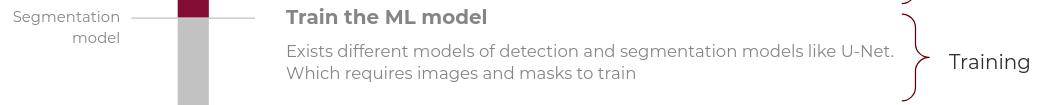

El modelo es una red neural profunda de **segmentación de objetos** de tipo CNN con una arquitectura **U-Net**. Fue desarrollada inicialmente para la segmentación de imágenes biomédicas sin embargo tiene un buen desempeño en muchas otras áreas. 
 
La arquitectura posee múltiples capas de down-sampling y up-sampling, las cuales están conectadas. De este modo se combina la información de capas que poseen activaciones de mayor precisión con los nodos de las capas anteriores que poseen mayor resolución.


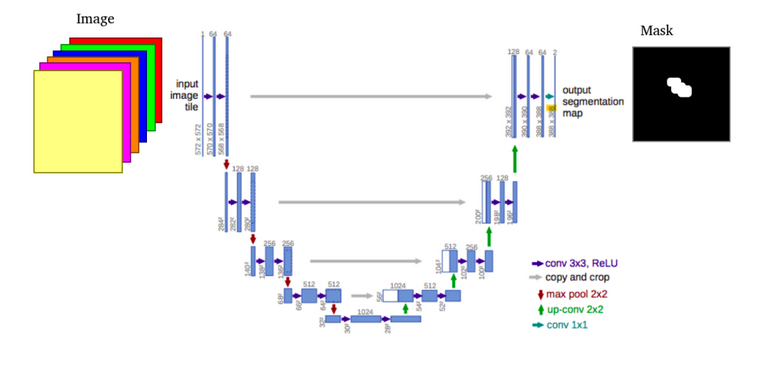



* **Input**: dataset de imágenes y máscaras
* **Output**: por cada imagen el modelo devuelve una imagen donde el valor de cada píxel es la probabilidad de encontrar al objeto de interés. Si se predice sobre varias clases, entonces la imagen de salida será de n-bandas , una por cada clase.
 
Este tipo de análisis cuenta con la ventaja de que las imágenes pueden ser no solo “visuales” RGB. Se le pueden añadir otras bandas y también información georeferenciada como otras capas GIS para mejorar los resultados.


**Instalamos unetseg**

In [ ]:
#!pip install folium==0.2.1

In [ ]:
#!pip install unetseg 

In [ ]:
#from unetseg.train import TrainConfig, train
#from unetseg.evaluate import plot_data_generator
#import os


**Configuramos el entrenamiento**:

*Obs:* Es útil usar un nombre para el archivo de pesos (nombre del modelo) que dé información sobre los parámetros de entrenamiento. Por ejemplo: < dim de las imagenes > < num de bandas > <num_de_clases > < size >_< stepsize > < step_per_epoch > <proyecto> <modelo> .h5 o similares

In [ ]:
#model_name='UNet_256x256_3N_2C_spe92_areas_verdes_modelo1.h5'

Veamos cuantas imágenes y máscaras hay en el dataset de entrenamiento para poder calcular el valor del parámetro: *steps_per_epoch*.

In [ ]:
#from glob import glob
#path_to_images=glob(os.path.join('../workshop/dataset/data_train/' +str(size)+'_'+str(step_size)+'/'+'images/*.tif'))
#path_to_mask=glob(os.path.join("../workshop/dataset/data_train/" +str(size)+'_'+str(step_size)+'/'+'extent/*.tif'))
#n=(len(path_to_images),len(path_to_mask))
#print(n)

In [ ]:
#config = TrainConfig(width=256,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc; y no menor a 80)
 #                    height=256,
  #                   n_channels=3,  #  número de canales de la imagen, rgb -> 3
   #                  n_classes=2, # número de clases a clasificar
    #                 apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes (rotación,)
     #                seed=42,
      #               epochs=20, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
       #              batch_size=16, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
        #             steps_per_epoch=92, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
         #            early_stopping_patience=5, # a medida que entrena se guardan los resultados del entrenamiento despues de cada epoch, si el error no varió luego de ¿¿10 ?? iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
          #           validation_split=0.2, # se divide la muestra en training (80% de los datos) y validation (20% de los datos) para calcular el error durante el proceso de entrenamiento
           #          test_split=0.1, # Cantidad de imágenes del dataset
            #         images_path=os.path.join("../workshop/dataset/data_train/" +str(size)+'_'+str(step_size)+'/'),#ruta a las imágenes generadas con Satproc
             #        model_path=os.path.join('../data/weights/', model_name),#  ruta del modelo entrenado
              #       model_architecture='unet',
               #      evaluate=True,
                #     class_weights= [0.2, 0.8]) 



**width** , **height** Es el tamaño de la imagen al ingresar en la red y debe ser múltiplo de 160 (160,256, 320, etc)
                     
  **n_channels** número de canales de la imagen  RGB -> 3

**n_classes** número de clases a predecir. 

**apply_image_augmentation** Si incluimos el proceso de image augmentation, éste crea nuevas imágenes a partir de pequeñas variaciones de la imagen original. 

**seed** seed del modelo

 **epochs** numero de veces que el dataset entero para por el proceso de entrenamiento 

**batch_size** cantidad de datos procesados por vez

**steps_per_epoch** normalmente igual a num_of_images/batch_size. Si el valor es mayor, aplica image agumentation.

**early_stopping_patience=True** tiempo de espera antes de cortar el proceso de entrenamiento si el error en los datos de validacion continua aumentando 

**validation_split=0.2** divide el dataset entre entrenamiento y validacion

**test_split=0.1** reserva una parte de los datos del dataset original para calcular las metricas finales

**images_path** ruta al dataset de entrenamiento

**model_path** ruta y nombre del modelo generado

**evaluate=True** para calcular las metricas finales

**class_weights** en caso de tener clases desbalanceadas puede ponderar mas una que otra al momento de calcular el error

*plot_data_generator* permite visualizar algunas de las imágenes y máscaras del dataset de entrenamiento.

In [ ]:
#plot_data_generator(num_samples=3, fig_size=(10, 10), train_config=config,img_ch = 2)

**Corremos el entrenamiento**

In [ ]:
#res_config = train(config) 

### Métrica del modelo 

Una de las métricas más utilizadas en computer vision es **Intersection over Unión (IoU)**.  
Ésta calcula el área de intersección entre la verdad de campo y la predicción sobre el área común a ambos. Tiende a 1 a medida que la predicción mejora.

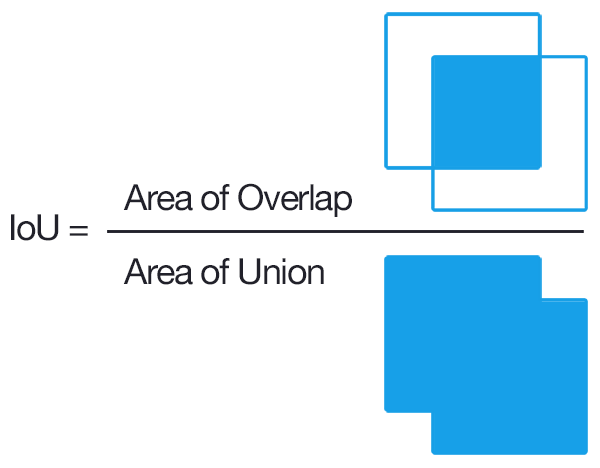

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'])
plt.plot(res_config.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history['mean_iou'])
plt.plot(res_config.history['val_mean_iou'])
plt.title('mean_iou')
plt.ylabel('val_mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()

![](https://drive.google.com/uc?export=view&id=1z7_KbtltZbCJwzci-_QgjBY-cH5aeYAK)

# 3) Predicción

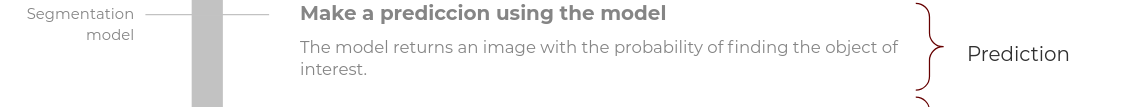

In [ ]:
!pip install folium==0.2.1


     |████████████████████████████████| 69 kB 3.5 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=e3660a407da70f6f922997133e9a3e317919fe66833adef4b8fd0e2678b9e046
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


In [ ]:
!pip uninstall -y h5py
!pip install h5py==2.10.0 
!pip install unetseg

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 5.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 60.5 MB 66 kB/s 
     |████████████████████████████████| 102 kB 66.4 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 11.2 MB 33.0 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 47.8 MB 56 kB/s 
     |████████████████████████████████| 930 kB 43.0 MB/s 
     |████████████████████████████████| 462

In [ ]:
!pip install pysatproc

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.3 MB 8.4 MB/s 
     |████████████████████████████████| 16.7 MB 265 kB/s 
     |████████████████████████████████| 1.0 MB 28.9 MB/s 
  Created wheel for pysatproc: filename=pysatproc-0.1.9-py2.py3-none-any.whl size=35759 sha256=e9664d2b9a60cb6934ef13061a7494511bde16c263bdf30e343e3a08deae8bec
  Stored in directory: /root/.cache/pip/wheels/cb/fd/5e/3353869723db14b8496985de8066a5977b8b5b5317f7079495
Successfully built pysatproc


In [ ]:
from unetseg.predict import PredictConfig, predict
from unetseg.evaluate import plot_data_results
import os

**Descarga de la imagen del barrio**

In [ ]:
barrio='Belgrano'

In [ ]:
path_to_images=os.path.join('./workshop/images_predict/'+barrio+'/')
!mkdir -p $path_to_images

bucket_imagen_barrio=os.path.join('gs://dym-workshops-public/gcba/workshop/'+barrio+'/imagen/') 


!gsutil -m cp -r $bucket_imagen_barrio $path_to_images

Copying gs://dym-workshops-public/gcba/workshop/Belgrano/imagen/Belgrano.tif...
- [1/1 files][  2.0 GiB/  2.0 GiB] 100% Done  53.7 MiB/s ETA 00:00:00           
Operation completed over 1 objects/2.0 GiB.                                      


**Descarga del archivo vectorial de área de interés**


In [ ]:
bucket_aoi_barrio=os.path.join('gs://dym-workshops-public/gcba/workshop/'+barrio+'/shp/'+barrio+'_1.geojson') 
aoi_predict='./workshop/aoi_predict/'

!mkdir $aoi_predict

!gsutil -m cp -r $bucket_aoi_barrio $aoi_predict

Copying gs://dym-workshops-public/gcba/workshop/Belgrano/shp/Belgrano_1.geojson...
/ [1/1 files][  1.1 KiB/  1.1 KiB] 100% Done                                    
Operation completed over 1 objects/1.1 KiB.                                      


**Decargamos el modelo ya entrenado**

In [ ]:
# Modelo ya entrenado
path_to_model='./workshop/data/'
!mkdir -p path_to_model

bucket_modelo='gs://dym-workshops-public/gcba/workshop/modelo'

!gsutil -m cp -r $bucket_modelo $path_to_model 

Copying gs://dym-workshops-public/gcba/workshop/modelo/UNet_256x256_3N_2C_spe92_areas_verdes_modelo1.h5...
- [1/1 files][356.3 MiB/356.3 MiB] 100% Done                                    
Operation completed over 1 objects/356.3 MiB.                                    


## 1.2 Generación del dataset de predicción

De modo similar, utilizamos *satproc_extract_chips* para generar el dataset de predicción. En este caso el archivo vectorial delimita las zonas de interés para la predicción y el *size* y *step_size* son iguales, ya que no es útil un overlap de las imágenes.

**dataset de predicción**

In [ ]:
size = 3000 
step_size=size
path_to_files = os.path.join('./workshop/images_predict/'+barrio+'/imagen/*.tif') #imagen del barrio
output_folder = os.path.join('./workshop/'+barrio+'/dataset/data_predict/'+str(size)+'_'+str(step_size)+'/')

vector_file_aoi = os.path.join('./workshop/aoi_predict/'+barrio+'_1.geojson')



!satproc_extract_chips \
    $path_to_files \
    -o  $output_folder \
    --size $size \
    --step-size $step_size \
    --aoi $vector_file_aoi 

Rasters:   0% 0/1 [00:00<?, ?it/s]
Belgrano.tif windows:   0% 0/25 [00:00<?, ?it/s]
Belgrano.tif windows:   4% 1/25 [00:00<00:10,  2.18it/s]
Belgrano.tif windows:  12% 3/25 [00:00<00:04,  5.47it/s]
Belgrano.tif windows:  20% 5/25 [00:00<00:02,  7.35it/s]
Belgrano.tif windows:  24% 6/25 [00:00<00:02,  7.22it/s]
Belgrano.tif windows:  28% 7/25 [00:01<00:02,  6.72it/s]
Belgrano.tif windows:  32% 8/25 [00:01<00:02,  6.88it/s]
Belgrano.tif windows:  36% 9/25 [00:01<00:02,  7.27it/s]
Belgrano.tif windows:  40% 10/25 [00:01<00:03,  3.83it/s]
Belgrano.tif windows:  48% 12/25 [00:02<00:02,  5.08it/s]
Belgrano.tif windows:  52% 13/25 [00:02<00:02,  5.18it/s]
Belgrano.tif windows:  56% 14/25 [00:02<00:01,  5.59it/s]
Belgrano.tif windows:  60% 15/25 [00:02<00:01,  6.07it/s]
Belgrano.tif windows:  64% 16/25 [00:02<00:01,  6.51it/s]
Belgrano.tif windows:  68% 17/25 [00:03<00:01,  4.30it/s]
Belgrano.tif windows:  72% 18/25 [00:03<00:01,  5.09it/s]
Belgrano.tif windows:  80% 20/25 [00:03<00:00,  6.38i

Consultamos el nombre del modelo

In [ ]:
!ls ./workshop/data/

UNet_256x256_3N_2C_spe92_areas_verdes_modelo1.h5


Definimos la configuración para la predicción. Debemos pasar la ruta a las imagenes del dataset de prediccion y al modelo.

In [ ]:
predict_config = PredictConfig(
                                    images_path=os.path.join('./workshop/'+barrio+'/dataset/data_predict/'+str(size)+'_'+str(step_size)+'/'), # ruta a las imagenes sobre las cuales queremos predecir
                                    results_path=os.path.join('./workshop/'+barrio+'/dataset/data_results/'+str(size)+'_'+str(step_size)+'/'), # ruta de destino para nuestra predicción
                                    batch_size=16,
                                    model_path=os.path.join('./workshop/data/','UNet_256x256_3N_2C_spe92_areas_verdes_modelo1.h5'),  #  ruta al modelo (.h5)
                                    height=256, 
                                    width=256,
                                    n_channels=3,
                                    n_classes=2,
                                    class_weights= [0.2,0.8])
          

In [ ]:
predict(predict_config)  # Ejecuta la predicción

Total images to predict (./workshop/Belgrano/dataset/data_predict/3000_3000/images/*.tif): 25
After skipping existing results: 25


100%|██████████| 2/2 [00:28<00:00, 14.11s/it]

Done!


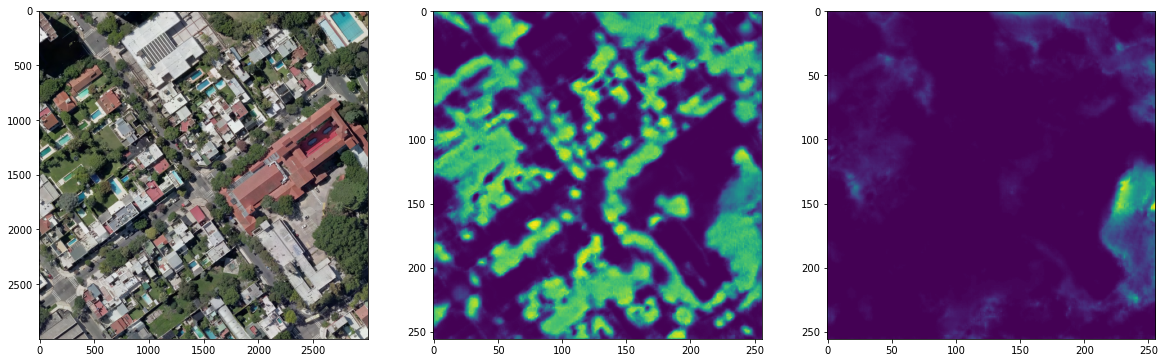

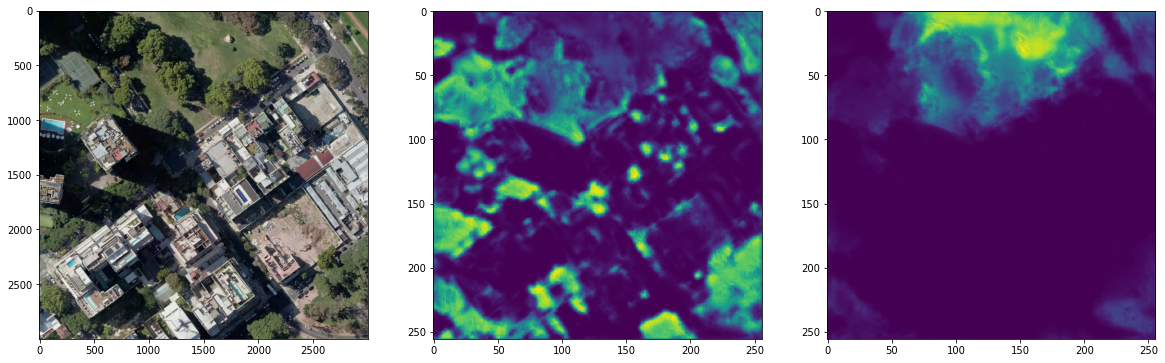

In [ ]:
plot_data_results(num_samples=2, fig_size=(5, 5), predict_config=predict_config, img_ch =2,n_bands =3)

![](https://drive.google.com/uc?export=view&id=1yGkmQnciitN1MFk4msxsvFTl7VAoBODI)

# 4) Post-procesamiento de los resultados

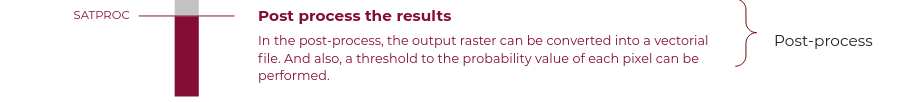

El post-procesamiento está enfocado en obtener resultados de mejor calidad. En esta etapa se aplica un umbral para conservar aquellas predicciones de mayor probabilidad. Asimismo, una vez poligonizado el resultado final se puede aplicar un filtro de mínima área para disminuir la cantidad de predicciones “ruidosas”.


### **Poligonizado**

La siguiente función aplica una rutina de poligonización sobre los resultados de la predicción del modelo y genera un archivo vectorial en formato GeoPackage (GPKG). La rutina aplica gdal_polygonize.py a cada chip resultado generando un GPKG para cada chip, y luego une todos estos archivos en uno solo, de manera eficiente.

Antes de unirlos también aplica un umbral sobre los valores de los rásteres, que en este caso representan la probabilidad (valores entre 0 y 1).


*filter_by_max_prob* es una funcion de satproc que filtra los resultados donde ningun prixel supera el umbral definido

**Umbral a la probabilidad para dos clases**

Definimos un umbral a la probabilidad para cada clase

In [ ]:

threshold_A=50
threshold_B=50

El siguiente código aplica un umbral a la probabilidad para cada clase y asigna:


*   Valor 100 a los píxeles de la clase "Parque"
*   Valor 200 a los píxeles de la clase "Vegetación"
*   Valor 1 al background

Esto se hace con el fin de transformar la imagen de probabilides de 2 bandas (binarias), en una imagen de una banda con dichos valores de pixeles.




In [ ]:
from tqdm import tqdm
import subprocess
import os

DEBUG=True
results_path = os.path.join('./workshop/'+barrio+'/dataset/data_results/'+str(size)+'_'+str(step_size)+'/') #ruta de los resultados de la predicción
#if DEBUG: print (results_path)

dest = os.path.join('./workshop/'+barrio+'/dataset/data_results/temp_postprocesamiento',str(size)+"_"+str(step_size)) # ruta de destino para el post-procesamiento
os.makedirs(dest, exist_ok=True)
#if DEBUG: print (dest)

files = next(os.walk(results_path))[2] #recorre los archivos
new_dir = os.path.join(dest, '1band_2classes','thr_'+str(threshold_A)+'_'+str(threshold_B)) #creamos un directorio para la imagen de 1 banda
os.makedirs(new_dir, exist_ok=True) #si no existe el directorio, lo crea
#if DEBUG: print (new_dir)
for file in files:
    if os.path.splitext(file)[-1]=='xml': continue

    result_dst = os.path.join(results_path,file)
    output_tif_path = os.path.join(dest, '1band_2classes/','thr_'+str(threshold_A)+'_'+str(threshold_B),file) #destino de la imagen de una banda
    exp = "((B<"+str(threshold_B)+")*(A >"+str(threshold_A)+")*199 ) + ((A<"+str(threshold_A)+")*(B >"+str(threshold_B)+")*99 ) +1" #cálculo para aplicar thresholds y asignar valores a los píxeles segun la clase
    cmd_calc = f'gdal_calc.py -A {result_dst} --A_band=1 -B {result_dst} --B_band=2  --outfile {output_tif_path} --calc="{exp}" --NoDataValue=0'
    subprocess.run(cmd_calc, shell=True)
    print("--",output_tif_path)

-- ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/Belgrano_3_4.tif
-- ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/Belgrano_0_1.tif
-- ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/Belgrano_0_2.tif
-- ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/Belgrano_0_3.tif
-- ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/Belgrano_0_6.tif
-- ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/Belgrano_2_4.tif
-- ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/Belgrano_0_9.tif
-- ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/Belgrano_2_6.tif
-- ./workshop/Belgrano/dataset/data_results/temp

Ahora transformamos la imagen de probabilidades de 2 bandas, en una imagen de una banda

In [ ]:
output_vrt = os.path.join(dest, '1band_2classes','thr_'+str(threshold_A)+'_'+str(threshold_B),'tiles.vrt')
output_tif = os.path.join(dest, '1band_2classes','thr_'+str(threshold_A)+'_'+str(threshold_B),'*.tif')
cmd_buildvrt = f'gdalbuildvrt {output_vrt} {output_tif}'
subprocess.run(cmd_buildvrt, shell=True)

CompletedProcess(args='gdalbuildvrt ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/tiles.vrt ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/*.tif', returncode=0)

**Poligonizado**

In [ ]:

output_shp_path = os.path.join('./workshp/'+barrio+'/dataset/data_results/', 'poligonize_classAB_thr_'+str(threshold_A)+'_'+str(threshold_B)+'_'+str(size)+'_'+str(step_size)+'.gpkg')
cmd_polygonize = f'gdal_polygonize.py {output_vrt} {output_shp_path}'
subprocess.run(cmd_polygonize, shell=True)


CompletedProcess(args='gdal_polygonize.py ./workshop/Belgrano/dataset/data_results/temp_postprocesamiento/3000_3000/1band_2classes/thr_50_50/tiles.vrt ./workshp/Belgrano/dataset/data_results/poligonize_classAB_thr_50_50_3000_3000.gpkg', returncode=1)

**Opcional:**
Para aplicar un filtro de mínima área primero debemos pasar los resultados a metros (utm) 

In [ ]:
#src_file = 'file_4326.gpkg'
#dst_file = 'file_utm_32721.gpkg'

#!ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:32721 -f 'GPKG' $dst_file $src_file

Luego filtramos aquellos polígonos que no cumplen con el valor de área mínima definido

In [ ]:
#min_area = 10

#input_path = dst_file
#output_path = "file_utm_32721.gpkg" 

#!ogr2ogr \
 #   -t_srs EPSG:32721 \
  #  -f "GPKG" \
  #  -sql "SELECT * FROM tabla m WHERE (ST_Area(geom) > $min_area) " \
   # -dialect SQLITE \
    #-nln results \
    #$output_path \
    #$input_path